# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..


In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

# Optimization Settings

In [5]:
observation = 'newly_infected' # 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 7
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

# Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.428571,61.142857,3.571429
1,2020-08-02,0.428571,69.000000,3.571429
2,2020-08-03,0.428571,76.714286,4.142857


# Initialize Parameter

In [7]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
method = RandomWalk(n_observations = df_obs.shape[0], device=device, dtype=dtype)
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

In [8]:
initial_newly_infected

array([34.14285714, 38.57142857, 44.42857143, 48.        , 52.71428571,
       55.85714286])

# Optimization

Step: 0, Learning Rate: 0.01998 Time: 0.1331, Comparison Loss: 45300876.0, Phi: 25.0 


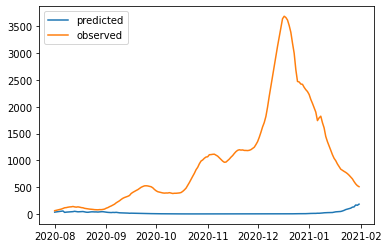

Step: 50, Learning Rate: 0.01900508845137668 Time: 0.1232, Comparison Loss: 4217872.5, Phi: 24.780141830444336 
Step: 100, Learning Rate: 0.018077747099331895 Time: 0.2163, Comparison Loss: 131688.5625, Phi: 24.752635955810547 


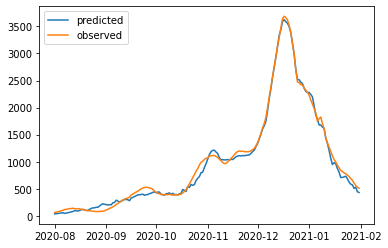

Step: 150, Learning Rate: 0.017195654786007063 Time: 0.1246, Comparison Loss: 36740.140625, Phi: 24.75139808654785 
Step: 200, Learning Rate: 0.016356603612983148 Time: 0.053, Comparison Loss: 21919.80078125, Phi: 24.75103187561035 


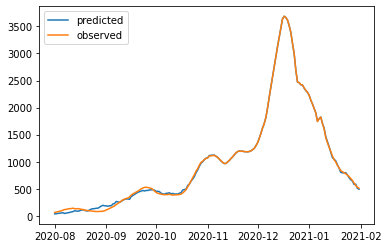

Step: 250, Learning Rate: 0.01555849341485746 Time: 0.0639, Comparison Loss: 16835.841796875, Phi: 24.75071144104004 
Step: 300, Learning Rate: 0.014799326502478864 Time: 0.0543, Comparison Loss: 13418.4619140625, Phi: 24.750492095947266 


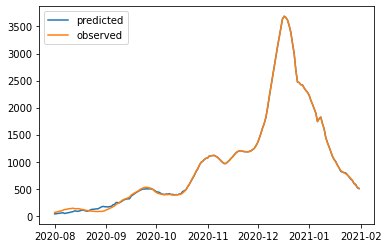

Step: 350, Learning Rate: 0.014077202662683376 Time: 0.0562, Comparison Loss: 11724.390625, Phi: 24.750308990478516 
Step: 400, Learning Rate: 0.013390314402014662 Time: 0.0587, Comparison Loss: 33995.5234375, Phi: 24.750144958496094 


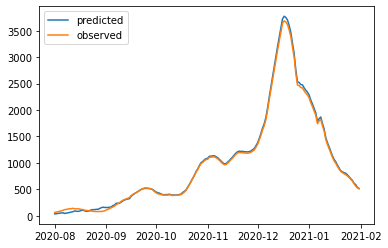

Step: 450, Learning Rate: 0.012736942422524105 Time: 0.0561, Comparison Loss: 9946.404296875, Phi: 24.749919891357422 
Step: 500, Learning Rate: 0.012115451318326462 Time: 0.0544, Comparison Loss: 9410.5234375, Phi: 24.749771118164062 


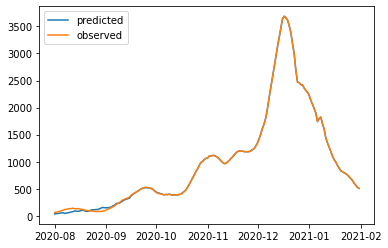

Step: 550, Learning Rate: 0.011524285482139275 Time: 0.0565, Comparison Loss: 8990.5419921875, Phi: 24.7496280670166 
Step: 600, Learning Rate: 0.010961965211560216 Time: 0.0558, Comparison Loss: 8642.5380859375, Phi: 24.749492645263672 


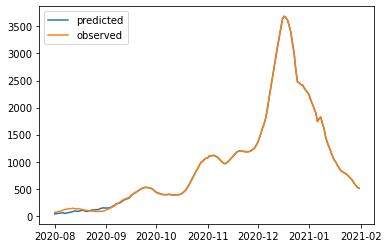

Step: 650, Learning Rate: 0.010427083005336134 Time: 0.0575, Comparison Loss: 8344.068359375, Phi: 24.749357223510742 
Step: 700, Learning Rate: 0.009918300040353342 Time: 0.057, Comparison Loss: 8081.751953125, Phi: 24.749229431152344 


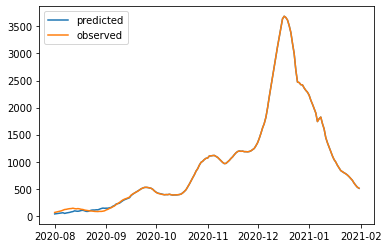

Step: 750, Learning Rate: 0.009434342820530944 Time: 0.0604, Comparison Loss: 7846.74365234375, Phi: 24.749107360839844 
Step: 800, Learning Rate: 0.008973999989229292 Time: 0.0553, Comparison Loss: 7633.09716796875, Phi: 24.748987197875977 


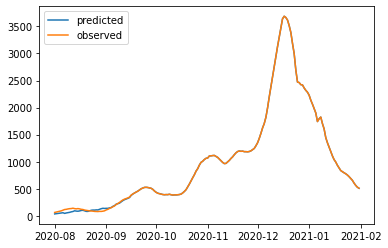

Step: 850, Learning Rate: 0.008536119297195001 Time: 0.0608, Comparison Loss: 7436.59228515625, Phi: 24.748870849609375 
Step: 900, Learning Rate: 0.008119604718453171 Time: 0.055, Comparison Loss: 7254.23681640625, Phi: 24.748756408691406 


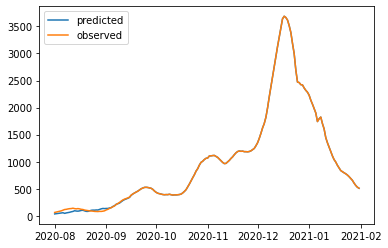

Step: 950, Learning Rate: 0.007723413706927829 Time: 0.0549, Comparison Loss: 7083.8125, Phi: 24.748647689819336 


In [9]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
list_R0 = []
list_sigma = []
list_phi = []
list_alpha = []

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)
  list_R0.append(method.get_R0().item())
  list_sigma.append(method.get_sigma().item())
  list_phi.append(dict_param['real_values']['phi'].item())
  list_alpha.append(dict_param['real_values']['alpha'].item())

  # forward pass
  expected = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss =  calc_mse(expected, observed) * dict_param['real_values']['phi'] # calc_poisson_loss(expected, observed) * dict_param['real_values']['phi'] #
  method_loss = method.calculate_loss() 
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss}, Phi: {dict_param['real_values']['phi']} ")

    if i % 100==0:
      plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

# Evaluation

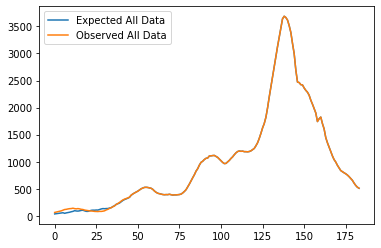

In [10]:
plt.plot(expected.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed.cpu().detach().numpy(),label='Observed All Data')
plt.legend()
plt.show()

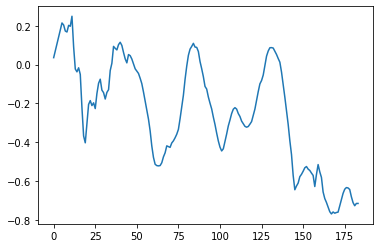

In [11]:
plt.plot(method.get_parameters()[0].cpu().detach().numpy())
plt.show()

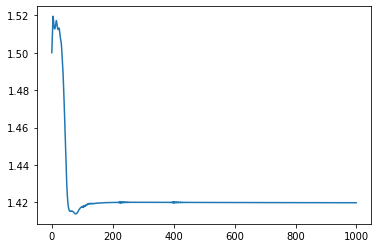

In [12]:
plt.plot(list_R0)

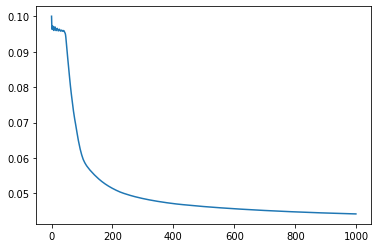

In [13]:
plt.plot(list_sigma)

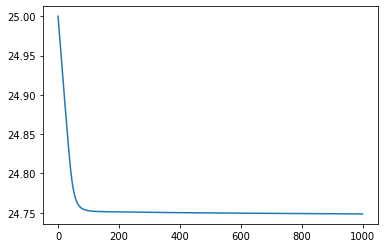

In [14]:
plt.plot(list_phi)

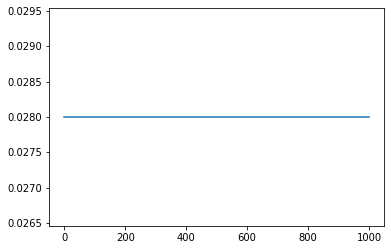

In [15]:
plt.plot(list_alpha)

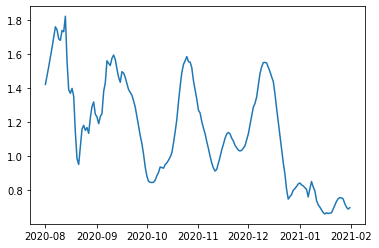

In [17]:
df_rvalue = pd.DataFrame()
df_rvalue['date'] = df_obs.Date
df_rvalue['R_t'] = method.calculate_R().detach().numpy()
df_rvalue.to_csv('data/inferred_rvalue_infected.csv', index=False)
plt.plot(df_rvalue['date'], df_rvalue['R_t'])